<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 33.17 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x796a4d570c10>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

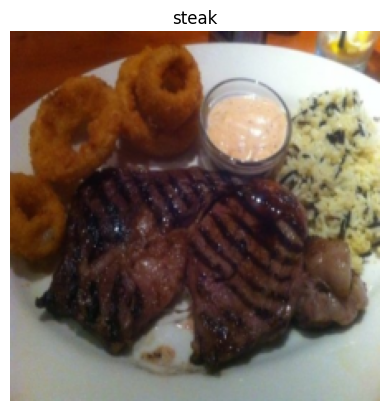

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16):
    super().__init__()
    self.patch_layer = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    self.flatten_patch = nn.Flatten(start_dim=2)

  def forward(self, x):
    return self.flatten_patch(self.patch_layer(x)).permute(0, 2, 1)


class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,  # table-3 from ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,  # Table-1 for "Layers" for ViT-base
               embedding_dim:int=768,  # hidden size D from Table-1 for ViT-base
               mlp_size:int=3072,  # table-1
               num_heads:int=12,  # table-2
               attn_dropout:float=0.0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,  # dropout for patch and position embeddings
               num_classes:int=1000):  # number of classes in our classification problem
    super().__init__()
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"
    self.num_patches = (img_size * img_size) // patch_size**2  # calculate the number of patches

    # create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    # create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # create the embedding dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # create the patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          embedding_dim=embedding_dim,
                                          patch_size=patch_size)

    # create a transformer encoder block
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                  nhead=num_heads,
                                                                                  dim_feedforward=mlp_size,
                                                                                  dropout=attn_dropout,
                                                                                  activation='gelu',
                                                                                  batch_first=True,
                                                                                  norm_first=True),
                                                     num_layers=num_transformer_layers,
                                                     enable_nested_tensor=False)

    # crate classifier head
    self.classifier_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]   # get the batch size

    # create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)  # -1 means to infer dimensions

    x = self.patch_embedding(x)  # create patch embedding

    # concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)  # (batch_size, number_of_patches+1, embedding_dim)

    # add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # apply dropout to patch embedding (directly after adding positional- to patch embeddings)
    x = self.embedding_dropout(x)

    # pass position and patch embedding to Transformer Encoder (equation 2 and 3)
    x = self.transformer_encoder(x)

    # put 0th index logit through classifier (equation 4)
    x = self.classifier_head(x[:, 0])

    return x

In [ ]:
set_seeds()
vit = ViT(num_classes=len(class_names))
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=17,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape       Output Shape      Param #           Trainable
ViT (ViT)                                          [1, 3, 224, 224]  [1, 3]            152,064           True
├─PatchEmbedding (patch_embedding)                 [1, 3, 224, 224]  [1, 196, 768]     --                True
│    └─Conv2d (patch_layer)                        [1, 3, 224, 224]  [1, 768, 14, 14]  590,592           True
│    └─Flatten (flatten_patch)                     [1, 768, 14, 14]  [1, 768, 196]     --                --
├─Dropout (embedding_dropout)                      [1, 197, 768]     [1, 197, 768]     --                --
├─TransformerEncoder (transformer_encoder)         [1, 197, 768]     [1, 197, 768]     --                True
│    └─ModuleList (layers)                         --                --                --                True
│    │    └─TransformerEncoderLayer (0)            [1, 197, 768]     [1, 197, 768]     7,087,872         True
│    │   

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [ ]:
%%writefile vit.py
import torch
from torch import nn

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16):
    super().__init__()
    self.patch_layer = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    self.flatten_patch = nn.Flatten(start_dim=2)

  def forward(self, x):
    return self.flatten_patch(self.patch_layer(x)).permute(0, 2, 1)


class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,  # table-3 from ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,  # Table-1 for "Layers" for ViT-base
               embedding_dim:int=768,  # hidden size D from Table-1 for ViT-base
               mlp_size:int=3072,  # table-1
               num_heads:int=12,  # table-2
               attn_dropout:float=0.0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,  # dropout for patch and position embeddings
               num_classes:int=1000):  # number of classes in our classification problem
    super().__init__()
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"
    self.num_patches = (img_size * img_size) // patch_size**2  # calculate the number of patches

    # create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    # create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # create the embedding dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # create the patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          embedding_dim=embedding_dim,
                                          patch_size=patch_size)

    # create a transformer encoder block
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                  nhead=num_heads,
                                                                                  dim_feedforward=mlp_size,
                                                                                  dropout=attn_dropout,
                                                                                  activation='gelu',
                                                                                  batch_first=True,
                                                                                  norm_first=True),
                                         num_layers=num_transformer_layers,
                                         enable_nested_tensor=False)

    # crate classifier head
    self.classifier_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]   # get the batch size

    # create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)  # -1 means to infer dimensions

    x = self.patch_embedding(x)  # create patch embedding

    # concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)  # (batch_size, number_of_patches+1, embedding_dim)

    # add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # apply dropout to patch embedding (directly after adding positional- to patch embeddings)
    x = self.embedding_dropout(x)

    # pass position and patch embedding to Transformer Encoder (equation 2 and 3)
    x = self.transformer_encoder(x)

    # put 0th index logit through classifier (equation 4)
    x = self.classifier_head(x[:, 0])

    return x

Writing vit.py


In [ ]:
!python vit.py

In [ ]:
from vit import ViT

model = ViT(num_classes=len(class_names))
summary(model=model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
data_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths to train and test images
train_dir_20_percent = data_path / "train"
test_dir_20_percent = data_path / "test"

In [ ]:
# get the pretrained weights
vit_b32_weights = torchvision.models.ViT_B_32_Weights.DEFAULT

# get the model's default transform
vit_b32_transforms = vit_b32_weights.transforms(antialias=True)

# createing new transform
auto_transforms_b32 = transforms.Compose([transforms.ToTensor(),
                                          vit_b32_transforms])

# creating dataloaders
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=auto_transforms_b32,
                                                                                                     batch_size=32)
train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79697b197760>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
vit_b32_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# configuring the vit
set_seeds()
vit_b32 = torchvision.models.vit_b_32(weights=vit_b32_weights)  # get the model
for param in vit_b32.parameters():
  param.requires_grad = False  # freezing the layers

# changing the mlp classifier head
features = vit_b32.heads[0].in_features
vit_b32.heads = nn.Linear(in_features=features, out_features=len(class_names), bias=True)
vit_b32.heads.requires_grad_(requires_grad=True)

summary(vit_b32,
        input_size=(1, 3, 224, 224),  # (batch_size, number_of_patches, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 7, 7]       (2,360,064)          False
├─Encoder (encoder)                                          [1, 50, 768]         [1, 50, 768]         38,400               False
│    └─Dropout (dropout)                                     [1, 50, 768]         [1, 50, 768]         --                   --
│    └─Sequential (layers)                                   [1, 50, 768]         [1, 50, 768]         --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 50, 768]         [1, 50, 768]         (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 50, 768]         [1, 5

In [ ]:
# setting up loss function
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.Adam(params=vit_b32.parameters(), lr=0.001)

In [ ]:
vit_b32_results = engine.train(model=vit_b32,
                               train_dataloader=train_dataloader_20_percent,
                               test_dataloader=test_dataloader_20_percent,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6693 | train_acc: 0.7521 | test_loss: 0.3141 | test_acc: 0.9256
Epoch: 2 | train_loss: 0.2465 | train_acc: 0.9250 | test_loss: 0.2145 | test_acc: 0.9290
Epoch: 3 | train_loss: 0.1958 | train_acc: 0.9396 | test_loss: 0.1781 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.1415 | train_acc: 0.9479 | test_loss: 0.1556 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.1208 | train_acc: 0.9625 | test_loss: 0.1472 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.1049 | train_acc: 0.9729 | test_loss: 0.1412 | test_acc: 0.9568
Epoch: 7 | train_loss: 0.1163 | train_acc: 0.9833 | test_loss: 0.1347 | test_acc: 0.9750
Epoch: 8 | train_loss: 0.0962 | train_acc: 0.9896 | test_loss: 0.1382 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.0737 | train_acc: 0.9896 | test_loss: 0.1181 | test_acc: 0.9597
Epoch: 10 | train_loss: 0.0675 | train_acc: 0.9917 | test_loss: 0.1148 | test_acc: 0.9597


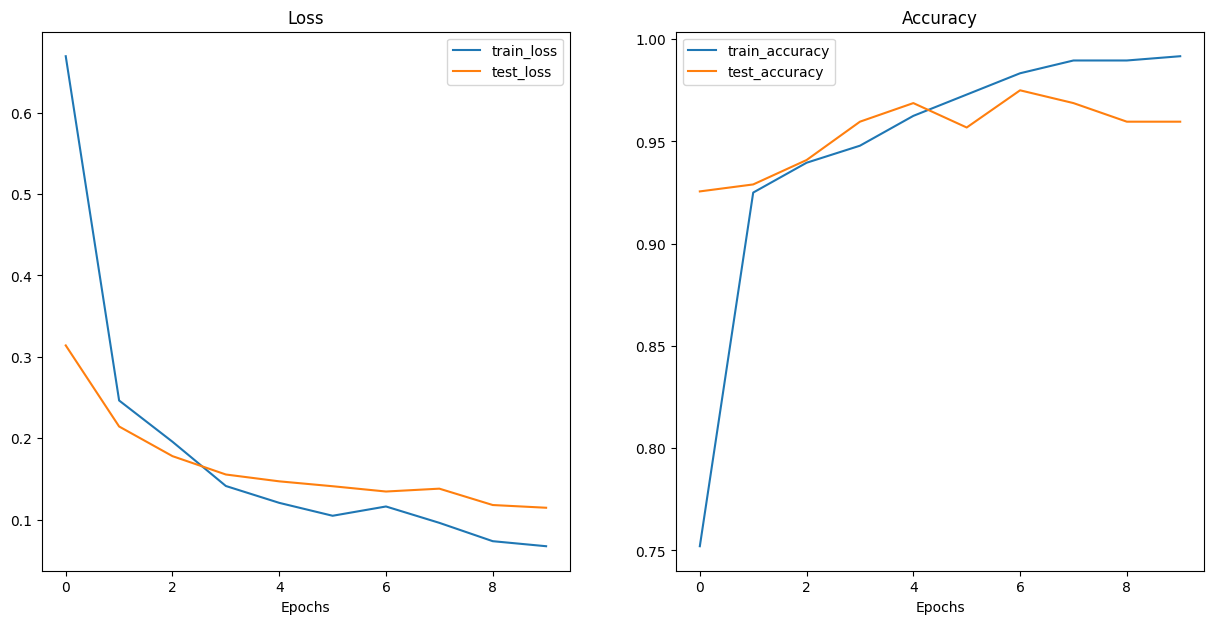

In [ ]:
plot_loss_curves(vit_b32_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# get the pretrained weights
vit_b16_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

# get the model's default transform
vit_b16_transforms = vit_b16_weights.transforms(antialias=True)

# createing new transform
auto_transforms_b16 = transforms.Compose([transforms.ToTensor(),
                                          vit_b16_transforms])

# creating dataloaders
train_dataloader_20_percent_b16, test_dataloader_20_percent_b16, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                             test_dir=test_dir_20_percent,
                                                                                                             transform=auto_transforms_b16,
                                                                                                             batch_size=32)
train_dataloader_20_percent_b16, test_dataloader_20_percent_b16, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79698071e440>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
vit_b16_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_20_percent_b16))
image_batch.shape

torch.Size([32, 3, 384, 384])

In [ ]:
# configuring the vit
set_seeds()
vit_b16 = torchvision.models.vit_b_16(weights=vit_b16_weights)  # get the model
for param in vit_b16.parameters():
  param.requires_grad = False  # freezing the layers

# changing the mlp classifier head
features = vit_b16.heads[0].in_features
vit_b16.heads = nn.Linear(in_features=features, out_features=len(class_names), bias=True)
vit_b16.heads.requires_grad_(requires_grad=True)

summary(vit_b16,
        input_size=(1, 3, 384, 384),  # (batch_size, number_of_patches, embedding_dim)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [ ]:
# setting up loss function
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.Adam(params=vit_b16.parameters(), lr=0.001)

In [ ]:
vit_b16_results = engine.train(model=vit_b16,
                               train_dataloader=train_dataloader_20_percent_b16,
                               test_dataloader=test_dataloader_20_percent_b16,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=5,
                               device=device)

In [ ]:
plot_loss_curves(vit_b16_results)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

In [ ]:
# ImageNet-21K Pretraining
'''
The vision transformers which weights are available in the torchvision.models module are pretrained on a large dataset.
Which is ImageNet_21K. It contains 21k classes. And millions of high quality images. This is the main reason behind the
state of the art performance of the vision transformers while we fine tune. Because it has allready learned huge complex
patterns whihch helps us in significantly smaller problems.
'''

# Learning Rate Warmup
'''
This refers to the changing of learning rate during training to help the model learn better and prevent the loss from exploding.
'''

# Learning Rate Decay
'''
Ensures smaller change in learning rate when model gets very closer to get convergence.
'''

# Gradient Clipping
'''
It reduce a model's gradients by a certain amount to prevent them from getting too large and causes the loss to explode.
'''